In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')


In [10]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
df.shape


(20800, 5)

In [12]:
df = df.drop(["id", "title", "author"], axis = 1)

In [13]:
df.isnull().sum()

text     39
label     0
dtype: int64

In [14]:
df = df.sample(frac = 1)

df.head()

,text,label
1053,To the moon. Get on board now or forever be pr...,1
16271,A new study offers important information to me...,0
1987,"REYNOSA, Tamaulipas — Diplomatic tensions h...",0
848,"YANGON, Myanmar — The rights lawyer had d...",0
3842,+++ Zu Wild geschaukelt: Spielendes Kind stürz...,1


In [15]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)

In [16]:
df.columns

Index(['text', 'label'], dtype='object')

In [17]:
df.head()

,text,label
0,To the moon. Get on board now or forever be pr...,1
1,A new study offers important information to me...,0
2,"REYNOSA, Tamaulipas — Diplomatic tensions h...",0
3,"YANGON, Myanmar — The rights lawyer had d...",0
4,+++ Zu Wild geschaukelt: Spielendes Kind stürz...,1


In [18]:
df_treino, df_teste = train_test_split(df, train_size=0.8 , test_size=0.2)

In [19]:
df_treino.shape

(16640, 2)

In [20]:
df_teste.shape

(4160, 2)

In [21]:
X = df_treino.iloc[:, 0] # Coluna dos dados pré-processados
y = df_treino.iloc[:, 1] # Coluna dos rótulos

X_test = df_teste.iloc[:, 0]  # Coluna dos dados pré-processados
y_test = df_teste.iloc[:, 1]  # Coluna dos rótulos

X = X.astype(str)
X_test = X_test.astype(str)

In [22]:
print("\nRótulos:")
print(y.head())
print("\nDados preprocessados:")
print(X.head())


Rótulos:
11771    0
11167    1
15615    1
3271     0
15166    1
Name: label, dtype: int64

Dados preprocessados:
11771    What’s that game they’re playing in the park i...
11167    \nThis article was written by Tyler Durden and...
15615    Desgranamos los perfiles de los posibles nuevo...
3271     The latest entry in the booming genre of   TV ...
15166    Anunnaki - Man and the family gods # Timotei S...
Name: text, dtype: object


In [23]:
np.random.seed(94)
tf.random.set_seed(94)

In [24]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.transform(y_test)

In [25]:
max_length = 5000  # Define o tamanho máximo das sequências
vocab_size = 100000  # Define o tamanho do vocabulário

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
# Tokenização e sequenciamento dos textos de treino
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Tokenização e sequenciamento dos textos de teste
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

In [26]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [27]:
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 16)          1600000   
                                                                 
 flatten (Flatten)           (None, 80000)             0         
                                                                 
 dense (Dense)               (None, 32)                2560032   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4160065 (15.87 MB)
Trainable params: 4160065 (15.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10
416/416 - 68s - loss: 0.2553 - accuracy: 0.8845 - val_loss: 0.0771 - val_accuracy: 0.9691 - 68s/epoch - 164ms/step
Epoch 2/10
416/416 - 54s - loss: 0.0274 - accuracy: 0.9914 - val_loss: 0.0672 - val_accuracy: 0.9730 - 54s/epoch - 129ms/step
Epoch 3/10
416/416 - 47s - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0608 - val_accuracy: 0.9790 - 47s/epoch - 114ms/step
Epoch 4/10
416/416 - 39s - loss: 9.8343e-04 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 0.9769 - 39s/epoch - 93ms/step
Epoch 5/10
416/416 - 35s - loss: 4.5863e-04 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9790 - 35s/epoch - 84ms/step
Epoch 6/10
416/416 - 27s - loss: 2.4372e-04 - accuracy: 1.0000 - val_loss: 0.0685 - val_accuracy: 0.9781 - 27s/epoch - 65ms/step
Epoch 7/10
416/416 - 24s - loss: 1.5345e-04 - accuracy: 1.0000 - val_loss: 0.0685 - val_accuracy: 0.9775 - 24s/epoch - 58ms/step
Epoch 8/10
416/416 - 23s - loss: 9.8264e-05 - accuracy: 1.0000 - val_loss: 0.0720 - val_accuracy: 0.9772 -

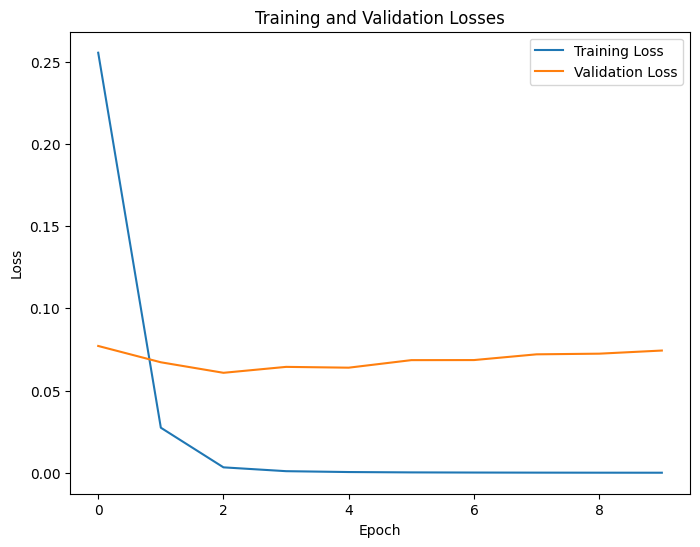

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

130/130 - 0s - loss: 0.0677 - accuracy: 0.9776 - 232ms/epoch - 2ms/step
Perda nos dados de teste: 0.0677
Acurácia nos dados de teste: 0.9776


In [33]:
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

130/130 [==============================] - 0s 2ms/step


In [34]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.9807407407407407
	Recall: 0.9735294117647059
	F1-score: 0.977121771217712
Class: 1
	Precision: 0.9747072599531615
	Recall: 0.9816037735849057
	F1-score: 0.9781433607520563
Class: macro avg
	Precision: 0.9777240003469512
	Recall: 0.9775665926748058
	F1-score: 0.9776325659848841
Class: weighted avg
	Precision: 0.9776659861086089
	Recall: 0.9776442307692308
	F1-score: 0.977642388961176
Macro Avg: {'precision': 0.9777240003469512, 'recall': 0.9775665926748058, 'f1-score': 0.9776325659848841, 'support': 4160}
Weighted Avg: {'precision': 0.9776659861086089, 'recall': 0.9776442307692308, 'f1-score': 0.977642388961176, 'support': 4160}


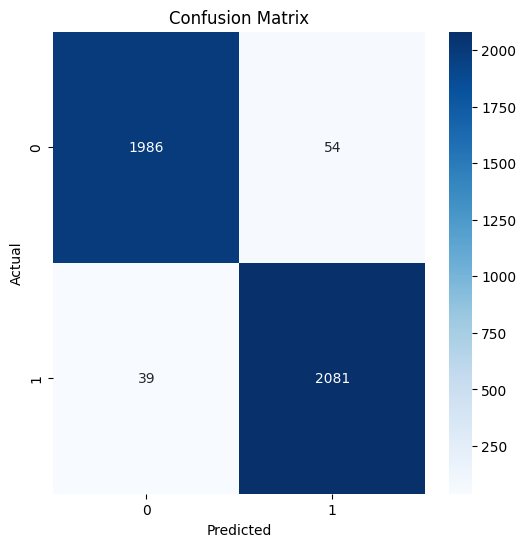

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [45]:
embedding_dim = 16

model_LSTM = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [46]:
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5000, 16)          1600000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                20736     
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1622849 (6.19 MB)
Trainable params: 1622849 (6.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
epochs = 10
history = model_LSTM.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/10
416/416 - 110s - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4997 - 110s/epoch - 264ms/step
Epoch 2/10
416/416 - 87s - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.4997 - 87s/epoch - 210ms/step
Epoch 3/10
416/416 - 87s - loss: 0.6958 - accuracy: 0.4944 - val_loss: 0.6933 - val_accuracy: 0.4997 - 87s/epoch - 208ms/step
Epoch 4/10
416/416 - 77s - loss: 0.6923 - accuracy: 0.4995 - val_loss: 0.6934 - val_accuracy: 0.4997 - 77s/epoch - 185ms/step
Epoch 5/10
416/416 - 79s - loss: 0.6918 - accuracy: 0.5043 - val_loss: 0.6937 - val_accuracy: 0.5000 - 79s/epoch - 189ms/step
Epoch 6/10
416/416 - 76s - loss: 0.6914 - accuracy: 0.5032 - val_loss: 0.6934 - val_accuracy: 0.5000 - 76s/epoch - 182ms/step
Epoch 7/10
416/416 - 74s - loss: 0.6907 - accuracy: 0.5020 - val_loss: 0.6934 - val_accuracy: 0.5003 - 74s/epoch - 177ms/step
Epoch 8/10
416/416 - 67s - loss: 0.6895 - accuracy: 0.4983 - val_loss: 0.6957 - val_accuracy: 0.5006 - 67s/epoch - 1

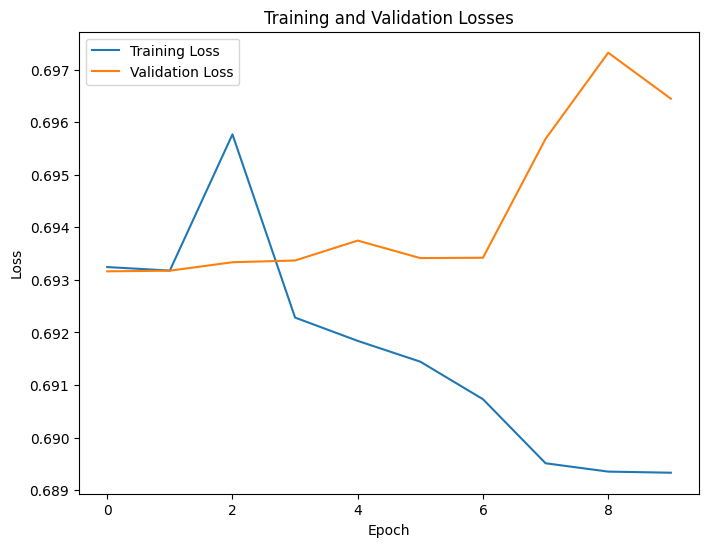

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
loss, accuracy = model_LSTM.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

130/130 - 7s - loss: 0.6953 - accuracy: 0.4913 - 7s/epoch - 56ms/step
Perda nos dados de teste: 0.6953
Acurácia nos dados de teste: 0.4913


In [55]:
y_pred = (model_LSTM.predict(padded_sequences_test) > 0.5).astype("int32")
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

130/130 [==============================] - 8s 63ms/step


In [ ]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

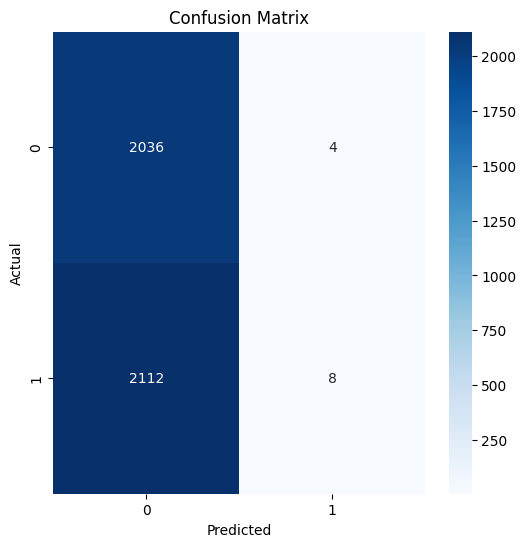

In [56]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()